In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import pyarrow.feather as ft
import catboost as cb
from datetime import datetime, timedelta

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from catboost_utils import MedianAPE

from tqdm import tqdm

from base_price import BasePrice, DoubleRegression

from matplotlib import pyplot as plt

warnings.simplefilter('ignore')
np.random.seed(10)

In [8]:
a = 2
vals = np.array([10 - a, 11, 12, 13, 14, 18, 20 + a])

x = np.linspace(10 - a, 20 + a, (10 + 2 * a) * 200 + 1).reshape(-1, 1)

dif = vals.reshape(1, -1) - x

In [75]:
y_true = np.array([10, 11, 12, 20, 21, 22, 30, 31, 32])

def optimal_median_ape(y):
    n = len(y)
    left = y.min()
    right = y.max()
    x = np.linspace(left, right, (right - left) * 10000 + 1).reshape(-1, 1)
    dif = y.reshape(1, -1) - x

    opt_i = np.apply_along_axis(lambda t: np.median(np.abs(t) / y), 1, dif).argmin()

    return [x[opt_i][0]] * n

y_pred = optimal_median_ape(y_true)
print(y_pred)
print(np.median(np.abs(y_pred - y_true) / y_true) * 100)

for idx in range(1, len(y_true)):
    print('-'*20, idx)
    left_child = optimal_median_ape(y_true[:idx])
    right_child = optimal_median_ape(y_true[idx:])
    left_score = np.median(np.abs(left_child - y_true[:idx]) / y_true[:idx]) * 100
    right_score = np.median(np.abs(right_child - y_true[idx:]) / y_true[idx:]) * 100
    print('left_score:', left_score)
    print('right_score:', right_score)
    print('total_score:', left_score * idx/len(y_true) + right_score * (len(y_true) - idx)/len(y_true))
    y_pred = left_child + right_child
    print(y_pred)
    print(np.median(np.abs(y_pred - y_true) / y_true) * 100)
print()
custom_pred = [hmean([11, 12])] * 4 + [hmean([30, 32])] * 5
print(custom_pred)
print(np.median(np.abs(custom_pred - y_true) / y_true) * 100)

[25.3585, 25.3585, 25.3585, 25.3585, 25.3585, 25.3585, 25.3585, 25.3585, 25.3585]
20.7547619047619
-------------------- 1
left_score: 0.0
right_score: 20.49281994047619
total_score: 18.215839947089947
[10.0, 25.0385, 25.0385, 25.0385, 25.0385, 25.0385, 25.0385, 25.0385, 25.0385]
19.230952380952377
-------------------- 2
left_score: 4.545454545454546
right_score: 18.51863636363637
total_score: 15.413484848484854
[10.0, 10.0, 26.0741, 26.0741, 26.0741, 26.0741, 26.0741, 26.0741, 26.0741]
18.518437499999997
-------------------- 3
left_score: 4.348181818181826
right_score: 17.460333333333335
total_score: 13.089616161616163
[11.4783, 11.4783, 11.4783, 20.9524, 20.9524, 20.9524, 20.9524, 20.9524, 20.9524]
4.762000000000004
-------------------- 4
left_score: 8.730166666666667
right_score: 3.225937499999998
total_score: 5.672261574074073
[10.4762, 10.4762, 10.4762, 10.4762, 30.9677, 30.9677, 30.9677, 30.9677, 30.9677]
4.762000000000004
-------------------- 5
left_score: 9.091000000000005
right

In [74]:
custom_pred = [hmean([21, 22])] * 6 + [hmean([30, 32])] * 3
print(custom_pred)
print(np.median(np.abs(custom_pred - y_true) / y_true) * 100)

[21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 30.967741935483875, 30.967741935483875, 30.967741935483875]
3.2258064516128893


In [66]:
custom_pred = [hmean([21, 22])] * 6 + [30] + [hmean([31, 32])] * 2
print(custom_pred)
print(np.median(np.abs(custom_pred - y_true) / y_true) * 100)

[21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 21.488372093023255, 30, 31.492063492063494, 31.492063492063494]
2.3255813953488413


In [72]:
custom_pred = [hmean([10, 12])] * 3 + [hmean([20, 22])] * 3 + [hmean([30, 32])] * 3
print(custom_pred)
print(np.median(np.abs(custom_pred - y_true) / y_true) * 100)

[10.909090909090908, 10.909090909090908, 10.909090909090908, 20.952380952380953, 20.952380952380953, 20.952380952380953, 30.967741935483875, 30.967741935483875, 30.967741935483875]
3.2258064516129186


In [42]:
hmean([21, 32], weights=[1, 1])

25.358490566037737

In [9]:
vals

array([ 8, 11, 12, 13, 14, 18, 22])

In [13]:
opt_i = np.apply_along_axis(lambda x: np.median(abs_pct(x)), 1, dif).argmin()
# opt_k = ...

864

In [11]:
def sqr(x):
    return x**2

def abs(x):
    return np.abs(x)

def abs_pct(x):
    return np.abs(x) / vals

def sqr_pct(x):
    return x**2 / vals**2


funcs = [sqr, abs, abs_pct, sqr_pct]
modes = [np.mean, np.median]

np.apply_along_axis(np.mean, 1, dif).shape

(2801,)

In [59]:
transformations = ["Id", "Log", "CoxBox"]

In [328]:
def check_metrics(a, transformation):
    vals = np.array([11, 12, 13, 14 + a])
    x = np.linspace(10 - a, 20 + a, (10 + 2 * a) * 200 + 1).reshape(-1, 1)

    f = lambda x: x
    inv_f = lambda x: x
    if transformation == "Log":
        vals = np.log(vals)
        x = np.log(x)
        f = np.log
        inv_f = np.exp
    elif transformation == "CoxBox":
        vals, fitted_lambda = boxcox(vals, lmbda=None)
        x = boxcox(x, lmbda=fitted_lambda)
        f = lambda x: boxcox(x, lmbda=fitted_lambda)
        inv_f = lambda x: inv_boxcox(x, fitted_lambda)

    dif = vals.reshape(1, -1) - x
    def sqr(x):
        return x**2
    def abs(x):
        return np.abs(x)
    def abs_pct(x):
        return np.abs(x) / vals
    def sqr_pct(x):
        return x**2 / vals**2

    funcs = [sqr, abs, abs_pct, sqr_pct]
    modes = [np.mean, np.median]
    flag = False
    inflag = False
    for mode in modes:
        for func in funcs:
            if inflag:
                inflag = False
                continue
            print(mode.__name__, func.__name__, ':', inv_f(x[np.apply_along_axis(lambda x: mode(func(x)), 1, dif).argmin()]))
            if flag:
                inflag = True
        flag = True

In [16]:
from scipy.stats import gmean, hmean

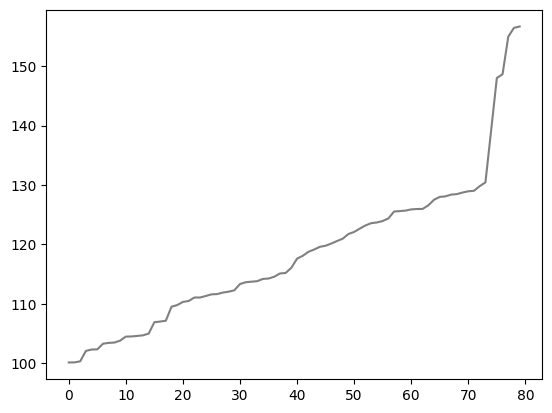

In [249]:
plt.plot(sorted_cur_r, color='gray')

In [298]:
np.quantile(my_vals, 0.1)

390000.0

749239.22 762500.00 747830.40 746358.22 771248.00 770792.00
750589.84 758500.00 749113.55 747590.80 764000.00 765024.00
756854.79 765000.00 755687.61 754482.02 771000.00 770504.00
751580.28 763500.00 750334.46 749041.88 766848.00 766360.00
743217.54 751500.00 741651.72 740034.06 765600.00 765048.00
754095.97 758500.00 752827.32 751511.66 767496.00 766840.00


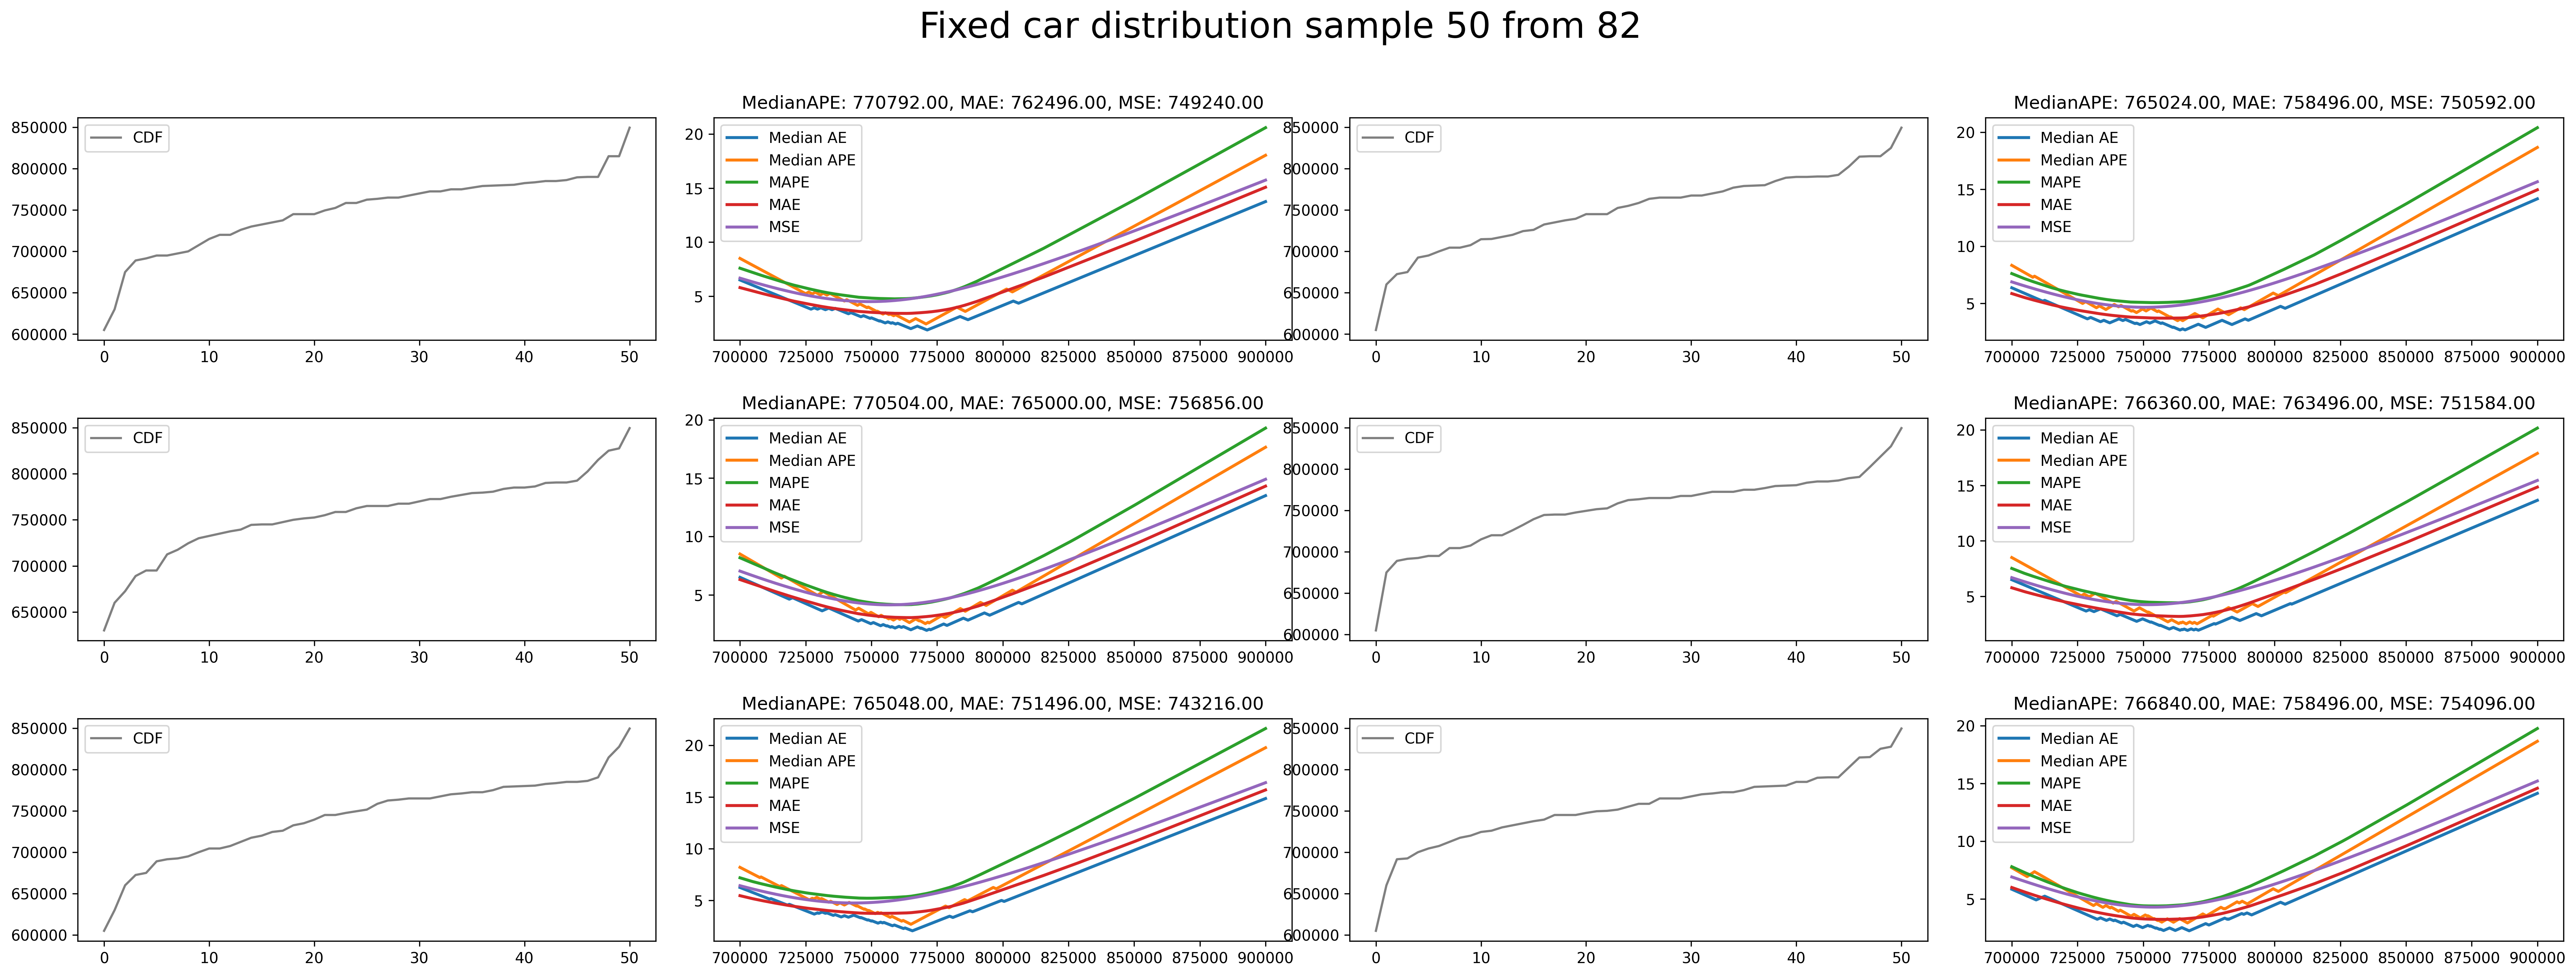

In [317]:
sz = 100

fig = plt.figure(figsize=(30, 10), facecolor='w', edgecolor='k', dpi=300)
plt.subplots_adjust(hspace=0.35, wspace=0.1)
fig.suptitle(f'Fixed car distribution sample 50 from 82', fontsize=24)

flag = True

for idx in range(1, 13, 2):
    r = np.random.random(size=(sz))
    r = np.random.lognormal(sigma=0.5, size=(sz))
    # r += np.random.binomial(1, 0.05, size=(sz))*0.5
    exp_r = np.exp(r * 0.25) * 100
    bias_r = 1_000_000 + r * 300_000 / 2

    cur_r = 500_000 + np.random.choice(my_vals, size=51, replace=False) / 2
    sorted_cur_r = np.sort(cur_r)

    if flag:
        ax = plt.subplot(3, 4, idx)
        ax.plot(sorted_cur_r, color='gray', label='CDF')
        ax.legend()

    x = np.linspace(700_000, 900_000, 1000 * 25 + 1).reshape(-1, 1)

    dr = cur_r.reshape(1, -1) - x

    est_median_ape = x[np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr).argmin()][0]
    est_median_ae = x[np.apply_along_axis(lambda x: np.median(np.abs(x)), 1, dr).argmin()][0]

    est_mae = x[np.apply_along_axis(lambda x: np.mean(np.abs(x)), 1, dr).argmin()][0]
    est_mse = x[np.apply_along_axis(lambda x: np.sqrt(np.mean(x**2)), 1, dr).argmin()][0]
    print(
        f'{np.mean(cur_r):.2f}',
        f'{np.median(cur_r):.2f}',
        f'{gmean(cur_r):.2f}',
        f'{hmean(cur_r):.2f}',
        f'{est_median_ae:.2f}',
        f'{est_median_ape:.2f}'
    )

    ax = plt.subplot(3, 4, idx + 1)
    ax.plot(x, 0.0001*np.apply_along_axis(lambda x: np.median(np.abs(x)), 1, dr), linewidth=2.0, label='Median AE')
    ax.plot(x, 100*np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr), linewidth=2.0, label='Median APE')
    ax.plot(x, 100*np.apply_along_axis(lambda x: np.mean(np.abs(x) / cur_r), 1, dr), linewidth=2.0, label='MAPE')
    ax.plot(x, 0.0001* np.apply_along_axis(lambda x: np.mean(np.abs(x)), 1, dr), linewidth=2.0, label='MAE')
    ax.plot(x, 0.0001*np.apply_along_axis(lambda x: np.sqrt(np.mean(x**2)), 1, dr), linewidth=2.0, label='MSE')
    ax.set_title(f'MedianAPE: {est_median_ape:.2f}, MAE: {est_mae:.2f}, MSE: {est_mse:.2f}')
    ax.legend()
plt.show()

749239.22 762500.00 747830.40 746358.22 771248.00 770792.00
750589.84 758500.00 749113.55 747590.80 764000.00 765024.00
756854.79 765000.00 755687.61 754482.02 771000.00 770504.00
751580.28 763500.00 750334.46 749041.88 766848.00 766360.00
743217.54 751500.00 741651.72 740034.06 765600.00 765048.00
754095.97 758500.00 752827.32 751511.66 767496.00 766840.00


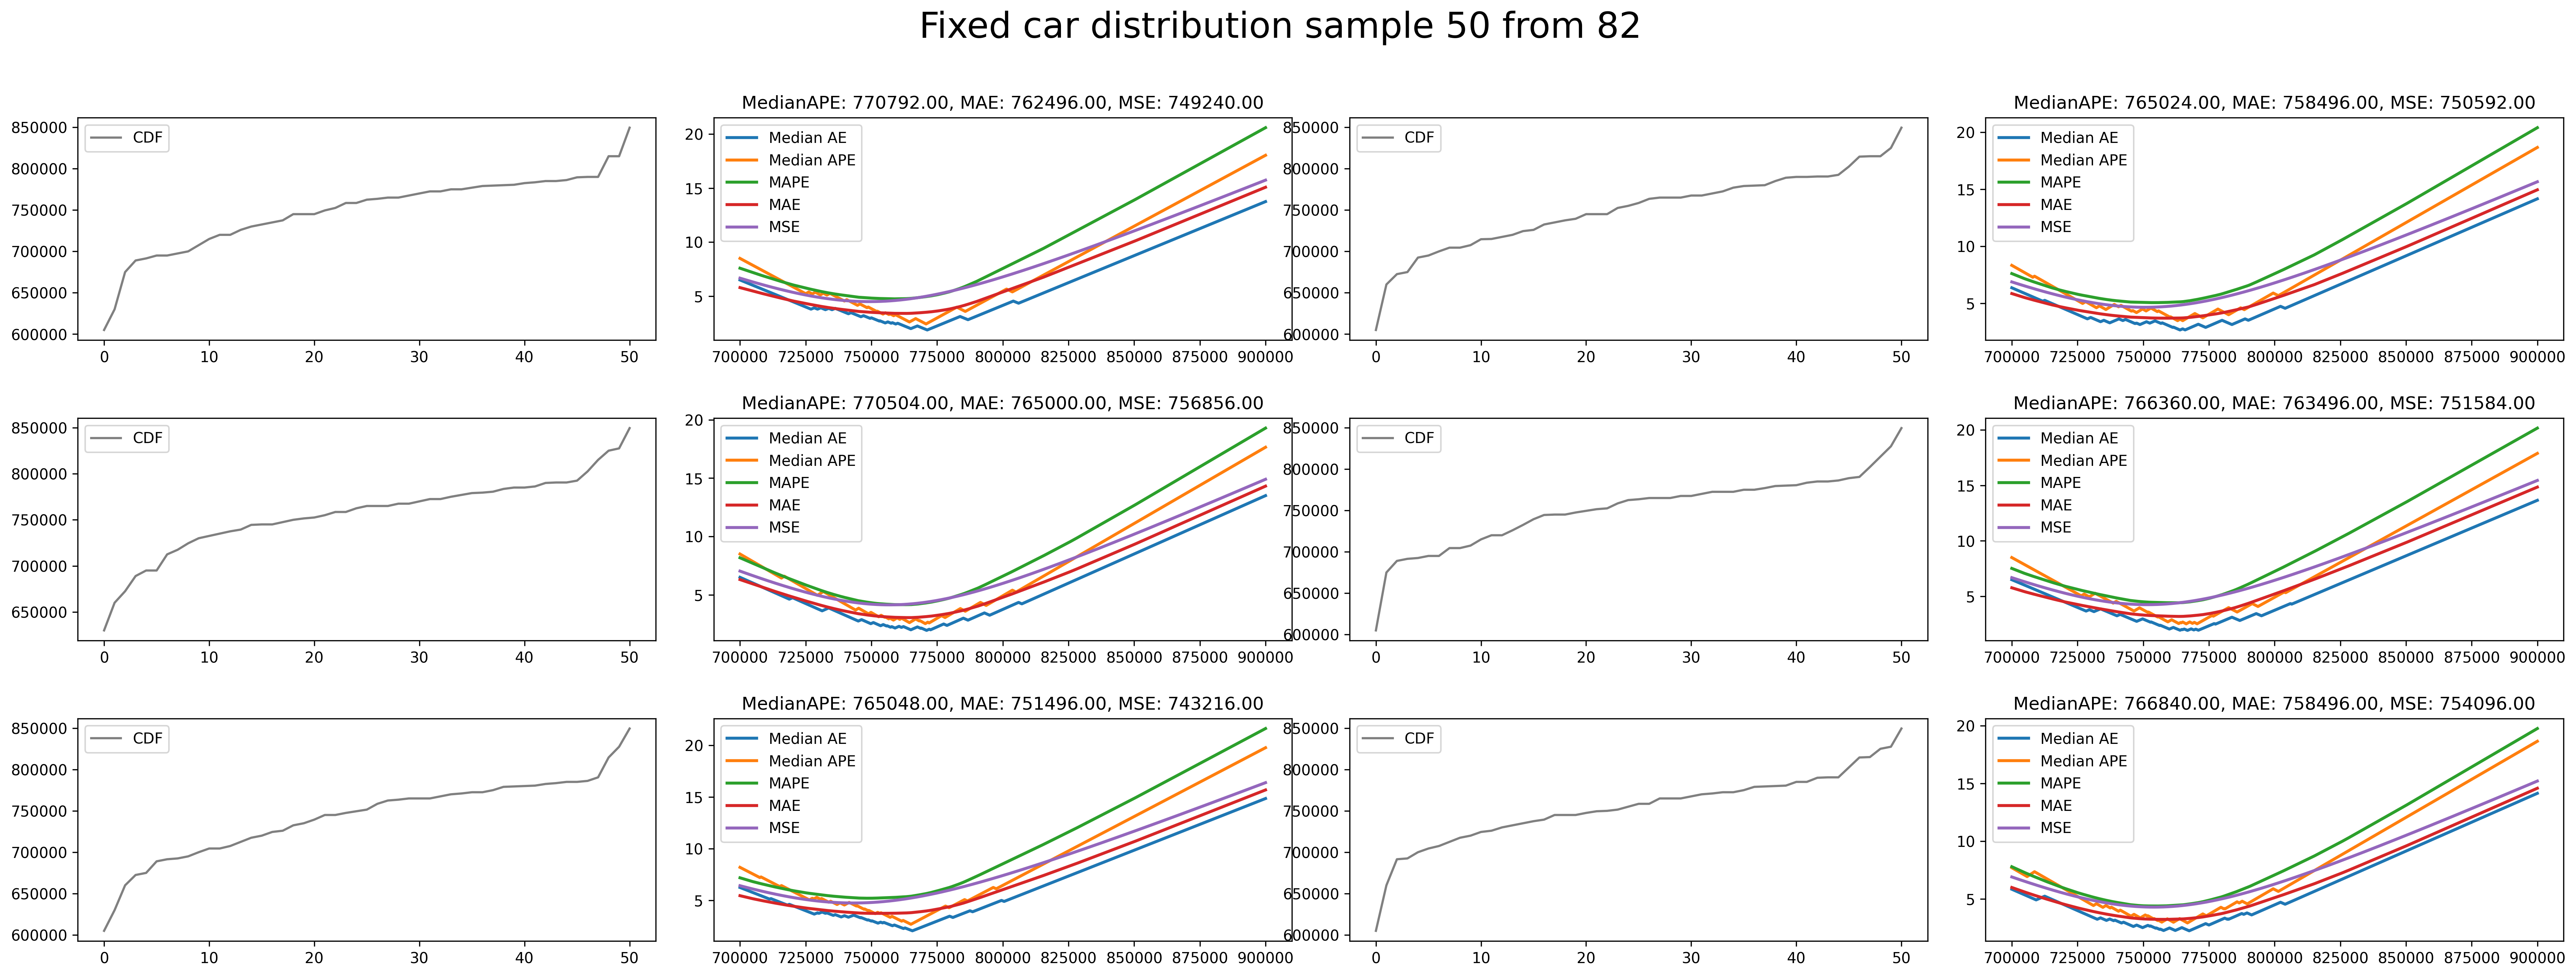

In [ ]:
sz = 100

fig = plt.figure(figsize=(30, 10), facecolor='w', edgecolor='k', dpi=300)
plt.subplots_adjust(hspace=0.35, wspace=0.1)
fig.suptitle(f'Fixed car distribution sample 50 from 82', fontsize=24)

flag = True

for idx in range(1, 13, 2):
    r = np.random.random(size=(sz))
    r = np.random.lognormal(sigma=0.5, size=(sz))
    # r += np.random.binomial(1, 0.05, size=(sz))*0.5
    exp_r = np.exp(r * 0.25) * 100
    bias_r = 1_000_000 + r * 300_000 / 2

    cur_r = 500_000 + np.random.choice(my_vals, size=51, replace=False) / 2
    sorted_cur_r = np.sort(cur_r)

    if flag:
        ax = plt.subplot(3, 4, idx)
        ax.plot(sorted_cur_r, color='gray', label='CDF')
        ax.legend()

    x = np.linspace(700_000, 900_000, 1000 * 25 + 1).reshape(-1, 1)

    dr = cur_r.reshape(1, -1) - x

    est_median_ape = x[np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr).argmin()][0]
    est_median_ae = x[np.apply_along_axis(lambda x: np.median(np.abs(x)), 1, dr).argmin()][0]

    est_mae = x[np.apply_along_axis(lambda x: np.mean(np.abs(x)), 1, dr).argmin()][0]
    est_mse = x[np.apply_along_axis(lambda x: np.sqrt(np.mean(x**2)), 1, dr).argmin()][0]
    print(
        f'{np.mean(cur_r):.2f}',
        f'{np.median(cur_r):.2f}',
        f'{gmean(cur_r):.2f}',
        f'{hmean(cur_r):.2f}',
        f'{est_median_ae:.2f}',
        f'{est_median_ape:.2f}'
    )

    ax = plt.subplot(3, 4, idx + 1)
    ax.plot(x, 0.0001*np.apply_along_axis(lambda x: np.median(np.abs(x)), 1, dr), linewidth=2.0, label='Median AE')
    ax.plot(x, 100*np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr), linewidth=2.0, label='Median APE')
    ax.plot(x, 100*np.apply_along_axis(lambda x: np.mean(np.abs(x) / cur_r), 1, dr), linewidth=2.0, label='MAPE')
    ax.plot(x, 0.0001* np.apply_along_axis(lambda x: np.mean(np.abs(x)), 1, dr), linewidth=2.0, label='MAE')
    ax.plot(x, 0.0001*np.apply_along_axis(lambda x: np.sqrt(np.mean(x**2)), 1, dr), linewidth=2.0, label='MSE')
    ax.set_title(f'MedianAPE: {est_median_ape:.2f}, MAE: {est_mae:.2f}, MSE: {est_mse:.2f}')
    ax.legend()
plt.show()

In [322]:
np.median((np.abs(sorted_cur_r-766840.00) / sorted_cur_r))

0.02931645569620253

In [441]:

np.median((np.abs(sorted_cur_r-766840.3908794789) / sorted_cur_r))

0.0293159609120522

In [434]:
tr_cur = (lambda x: x[(x > np.quantile(x, 0.1)) & (x < np.quantile(x, 0.9))])(sorted_cur_r)
tr_cur, tr_lmbda = boxcox(tr_cur)
anx, bnx = inv_boxcox(np.quantile(tr_cur, 0.25, method='interpolated_inverted_cdf'), tr_lmbda), inv_boxcox(np.quantile(tr_cur, 0.75, method='interpolated_inverted_cdf'), tr_lmbda)

In [435]:
tr_lmbda

6.252982818272975

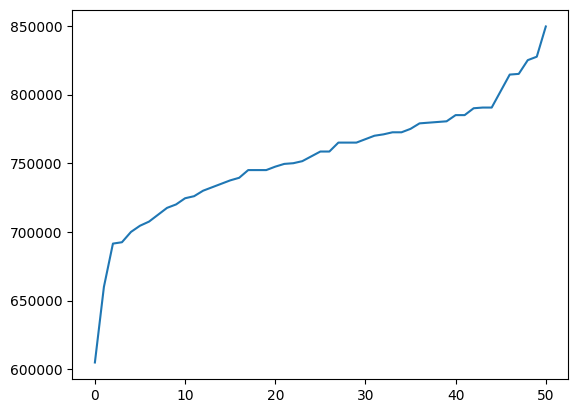

In [436]:
plt.plot(sorted_cur_r)

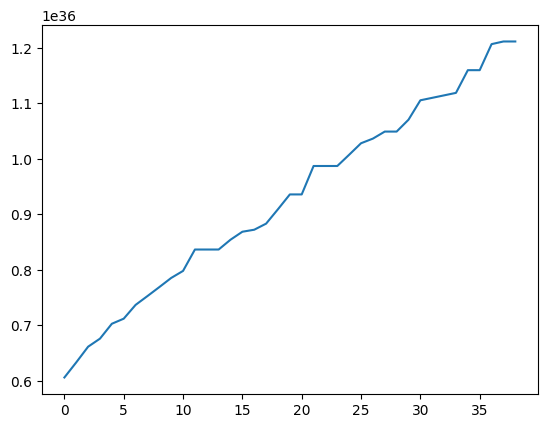

In [437]:
plt.plot(tr_cur)

In [439]:
hmean([anx, bnx])

754568.9651290015

In [324]:
ltr = len(sorted_cur_r) // 2
for jdx in range(0, ltr + (ltr % 2)):
    print(jdx, hmean([sorted_cur_r[jdx], sorted_cur_r[jdx + ltr]]))

0 673109.6442977631
1 705830.1022206555
2 726395.4685890833
3 726946.8267581476
4 731058.0204778158
5 734651.8342391304
6 737428.0879864637
7 740596.5621840243
8 743984.899328859
9 745326.6331658291
10 748899.6332110704
11 751566.7774086378
12 753938.3901954289
13 755504.132231405
14 757066.9745958429
15 760509.0311986863
16 761515.0572899601
17 766840.3908794789
18 767075.8710517747
19 767075.8710517747
20 774024.1935483871
21 780649.2966751918
22 781150.1597444089
23 786536.6317792578
24 789589.2575039493
25 801425.0621890547


In [307]:
np.quantile(np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr), 0.2)

0.03808122414608462

In [175]:
np.apply_along_axis(lambda x: np.median(np.abs(x) / cur_r), 1, dr)

array([0.06100898, 0.06101442, 0.06100827, 0.06101302, 0.06098505,
       0.06098765, 0.06103111, 0.06107456, 0.06111802, 0.06116148])

In [172]:
[sorted_cur_r[10_000], sorted_cur_r[30_000]]

[107.59797884800491, 122.49268833835195]

In [165]:
np.apply_along_axis(lambda x: np.median(np.abs(x)), 1, dr)[50:60]

array([7.48900293, 7.48580656, 7.48602412, 7.48635065, 7.48626599,
       7.48616816, 7.48529168, 7.48414915, 7.4809861 , 7.480988  ])

In [163]:
np.median(np.abs(dr), axis=1)[50:60]

array([7.48900293, 7.48580656, 7.48602412, 7.48635065, 7.48626599,
       7.48616816, 7.48529168, 7.48414915, 7.4809861 , 7.480988  ])

In [161]:
x[np.median(np.abs(dr), axis=1).argmin()]

array([110.435])

In [398]:
hmean([11, 12, 13, 14], weights=[0, 0, 1, 1])

13.481481481481481

In [400]:
np.median(np.abs(np.array([11, 12, 13, 14]) - 13.481481481481481) / np.array([11, 12, 13, 14]))

0.08024691358024691

In [329]:
for a in [0, 2, 4]:
    print(np.array([11, 12, 13, 14 + a]))
    for tr in transformations:
        print(tr)
        check_metrics(a, tr)

[11 12 13 14]
Id
mean sqr : [12.5]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.3]
median sqr : [12.]
median abs_pct : [12.48]
Log
mean sqr : [12.45]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.37]
median sqr : [12.96]
median abs_pct : [12.485]
CoxBox
mean sqr : [12.485]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.315]
median sqr : [12.99]
median abs_pct : [12.48]
[11 12 13 16]
Id
mean sqr : [13.]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.53]
median sqr : [12.]
median abs_pct : [11.48]
Log
mean sqr : [12.87]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.69]
median sqr : [11.96]
median abs_pct : [11.485]
CoxBox
mean sqr : [12.56]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.56]
median sqr : [11.845]
median abs_pct : [11.46]
[11 12 13 18]
Id
mean sqr : [13.5]
mean abs : [12.]
mean abs_pct : [12.]
mean sqr_pct : [12.67]
median sqr : [12.]
median abs_pct : [11.48]
Log
mean sqr : [13.255]
mean abs : [12.]
mean abs_p

In [57]:
for mode in modes:
    for func in funcs:
        print(mode.__name__, func.__name__, ':', x[np.apply_along_axis(lambda x: mode(func(x)), 1, dif).argmin()])

mean sqr : [14.]
mean abs : [13.]
mean abs_pct : [13.]
mean sqr_pct : [12.97]
median sqr : [12.]
median abs : [12.]
median abs_pct : [12.925]
median sqr_pct : [12.925]


In [52]:
for mode in modes:
    for func in funcs:
        print(mode.__name__, func.__name__, ':', x[np.apply_along_axis(lambda x: mode(func(x)), 1, dif).argmin()])

mean sqr : [14.]
mean abs : [13.]
mean abs_pct : [12.]
mean sqr_pct : [10.375]
median sqr : [13.]
median abs : [13.]
median abs_pct : [12.925]
median sqr_pct : [12.925]


In [40]:
for mode in modes:
    for func in funcs:
        print(mode.__name__, func.__name__, ':', x[np.apply_along_axis(lambda x: mode(func(x)), 1, dif).argmin()])

mean sqr : [14.]
mean abs : [13.]
mean abs_pct : [12.]
mean sqr_pct : [11.99]
median sqr : [13.]
median abs : [13.]
median abs_pct : [12.92]
median sqr_pct : [12.92]


In [62]:
5 / np.sum(1/ np.array([11 - a, 12, 13, 14, 20 + a]))

8.323170731707318

In [29]:
x[np.apply_along_axis(np.mean, 1, dif).argmax()]

array([9.])

In [8]:
x

array([ 9.  ,  9.05,  9.1 ,  9.15,  9.2 ,  9.25,  9.3 ,  9.35,  9.4 ,
        9.45,  9.5 ,  9.55,  9.6 ,  9.65,  9.7 ,  9.75,  9.8 ,  9.85,
        9.9 ,  9.95, 10.  , 10.05, 10.1 , 10.15, 10.2 , 10.25, 10.3 ,
       10.35, 10.4 , 10.45, 10.5 , 10.55, 10.6 , 10.65, 10.7 , 10.75,
       10.8 , 10.85, 10.9 , 10.95, 11.  , 11.05, 11.1 , 11.15, 11.2 ,
       11.25, 11.3 , 11.35, 11.4 , 11.45, 11.5 , 11.55, 11.6 , 11.65,
       11.7 , 11.75, 11.8 , 11.85, 11.9 , 11.95, 12.  , 12.05, 12.1 ,
       12.15, 12.2 , 12.25, 12.3 , 12.35, 12.4 , 12.45, 12.5 , 12.55,
       12.6 , 12.65, 12.7 , 12.75, 12.8 , 12.85, 12.9 , 12.95, 13.  ,
       13.05, 13.1 , 13.15, 13.2 , 13.25, 13.3 , 13.35, 13.4 , 13.45,
       13.5 , 13.55, 13.6 , 13.65, 13.7 , 13.75, 13.8 , 13.85, 13.9 ,
       13.95, 14.  , 14.05, 14.1 , 14.15, 14.2 , 14.25, 14.3 , 14.35,
       14.4 , 14.45, 14.5 , 14.55, 14.6 , 14.65, 14.7 , 14.75, 14.8 ,
       14.85, 14.9 , 14.95, 15.  , 15.05, 15.1 , 15.15, 15.2 , 15.25,
       15.3 , 15.35,

In [286]:
PATH = '../data'

TRAIN_DATA = 'project_train.f'
TEST_DATA = 'project_test_public.f'
OPTION = 'option_names.csv'

TRAIN_PATH = os.path.join(PATH, TRAIN_DATA)
TEST_PATH = os.path.join(PATH, TEST_DATA)
OPTION_PATH = os.path.join(PATH, OPTION)

data = ft.read_feather(TRAIN_PATH)
options = pd.read_csv(OPTION_PATH, index_col='id')
data.shape

(1424484, 70)

In [289]:
mask = data.brand.eq('Mitsubishi') & data.model.eq('Lancer') & data.equipment.eq('Базовая') & data.generation.eq('X (2007—2010)') & data.year.eq(2008) & data.modification.eq('1.8 CVT (143 л.с.)')

In [294]:
my_vals = data[mask].actual_price.values

In [287]:
data = data[data.actual_price.notna()]

In [288]:
(data.brand + data.model + data.equipment + data.generation + data.year.astype(str) + data.modification).value_counts()

AudiQ3BaseI (2011—2014)20132.0 TFSI quattro S tronic (170 л.с.)                         97
MitsubishiLancerБазоваяX (2007—2010)20081.8 CVT (143 л.с.)                              82
AudiQ3BaseI (2011—2014)20122.0 TFSI quattro S tronic (170 л.с.)                         81
FordFocusTitaniumIII рестайлинг (2014—2019)20171.5 EcoBoost AT (150 л.с.)               79
Mercedes-BenzCLA-классSportC118 (2019—2023)2019CLA 200 1.3 7G-DCT (150 л.с.)            71
                                                                                        ..
RenaultSandero StepwaySpecial EditionII рестайлинг (2018—2023)20191.6 CVT (113 л.с.)     1
RenaultSandero StepwayDriveII рестайлинг (2018—2023)20201.6 CVT (113 л.с.)               1
RenaultSandero StepwayDriveII рестайлинг (2018—2023)20181.6 CVT (113 л.с.)               1
RenaultSandero StepwaySpecial EditionII рестайлинг (2018—2023)20211.6 CVT (113 л.с.)     1
HyundaiTucsonRock EditionIII рестайлинг (2018—2023)20182.0 AT (150 л.с.)                 1

In [4]:
data['price'] = pd.to_numeric(data['price'])

In [5]:
data.description.sample(10)

1332864    Компания “МОТОР ЛЕНД” имеет успешный опыт прод...
1026478    Новое поступление в Автосалон CAR CITY! Рады в...
1051048    Машина в очень хорошем состоянии,мотор работае...
1314218    Присутствуют сколы и мелкие царапины! Крашены ...
1237557    Авто для своих лет, сохранилось хорошо.\nВсе с...
33567      На отличном бодром ходу , доедет куда угодно в...
1153886                          Машина в отличном состоянии
224451     Абсолютно новый автомобиль! \n Двухцветный кож...
66344      Отличное состояние. Я владелец, оформлен на же...
1258448    На ходу. Заводиться передвигается ,за месяц до...
Name: description, dtype: object

In [6]:
bm = data[['brand', 'model']].drop_duplicates().groupby('model').agg(['count', lambda x: x.unique()])
mask = bm.loc[:, ('brand', 'count')] > 1

bm[mask]

brand                            
         count                  <lambda_0>
model                                     
2110         2        [Богдан, ВАЗ (LADA)]
Bongo        2                [Kia, Mazda]
Corsa        2              [Toyota, Opel]
Gentra       2             [Daewoo, Ravon]
Matrix       2           [Toyota, Hyundai]
Nexia        3  [Chevrolet, Ravon, Daewoo]
Niva         2     [Chevrolet, ВАЗ (LADA)]
Sprinter     2     [Mercedes-Benz, Toyota]
V5           2           [FAW, Brilliance]

In [7]:
data[data.model.eq('Bongo')].groupby('brand').year.min()

brand
Kia      2004
Mazda    1983
Name: year, dtype: int64

In [8]:
data.description.apply(lambda x: '✅' in x if x else False).sum()

94745

In [9]:
data_advert = data[data.actual_price.isna()]
data_dealer = data[data.actual_price.notna()]

In [10]:
data_dealer.shape

(81426, 70)

In [11]:
data_advert

,actual_price,price,start_date,close_date,sale_end_date,brand,model,generation,modification,equipment,...,electroprivod_mult,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult
0,NaN,1950000.0,2023-02-18 13:37:49.603445,2023-02-19 15:06:28.603039,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,[13729],"[13783,13784]","[13763,13764,13765,13766,13767,13768,13769,137...","[13721,13722,13723,13724]",None,"[13751,13752,13753,13754,13755]","[13739,13740,13741,13742,13744,13745,13746]","[13747,13748,13749]",[13719],[13713]
1,NaN,1999000.0,2023-02-11 19:49:43.158681,2023-02-24 11:04:43.685727,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,"[13729,13733]","[13783,13784,13785]","[13763,13764,13765,13767,13768,13769,13770,137...","[13721,13723,13724]",None,"[13751,13753,13754,13755]","[13739,13740,13741,13742,13744,13745,13746]","[13748,13749]",[13719],"[13712,13713]"
2,NaN,1780000.0,2023-02-04 14:39:08.813905,2023-02-24 20:48:25.210683,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),None,...,"[13729,13731,13733]",[13783],"[13768,13772]",None,None,"[13751,13752,13753,13754]","[13740,13741,13742,13744,13745,13746]",[13749],None,None
3,NaN,1900000.0,2023-02-04 08:04:20.229815,2023-02-15 17:20:49.248078,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Highline,...,"[13729,13731,13733]","[13783,13784,13785]","[13763,13764,13765,13768,13769,13770,13771,13772]","[13721,13723,13724]",None,"[13751,13752,13753,13754,13755]","[13739,13740,13741,13742,13743,13744,13745,13746]","[13747,13749]",[13719],"[13712,13713]"
4,NaN,1650000.0,2023-02-04 01:42:29.723361,2023-02-04 12:26:13.572696,NaT,Volkswagen,Passat,B8 (2014—2020),2.0 TDI DSG (150 л.с.),Conceptline,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424479,NaN,440000.0,2022-03-12 18:26:29.843707,2022-03-13 17:57:18.947006,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,"[13731,13733]",None,"[13764,13765,13770,13771]",[13724],None,[13751],None,[13748],None,None
1424480,NaN,385000.0,2022-03-09 06:13:27.888078,2022-03-09 16:02:01.600249,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None
1424481,NaN,485000.0,2022-03-06 17:47:12.636290,2022-03-16 17:16:43.982866,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None
1424482,NaN,477000.0,2022-03-05 15:23:52.626344,2022-04-01 09:33:01.959260,NaT,Toyota,Ipsum,M10 (1995—2001),2.0 4WD AT (135 л.с.),Базовая,...,None,None,None,None,None,None,None,None,None,None


In [12]:
data.iloc[5].description

'✅Продажа от Официального дилера Автосеть РФ Уфа✅\n\n✅Заводской окрас\n✅Хорошее техническое состояние узлов и агрегатов.\n\n🔥Специальные условия на покупку:\n\n⚡ Выгода при покупке в Trade-In до 30 000 руб.;\n⚡ Выгода при покупке в кредит до 35 000 руб.;\n⚡ Первоначальный взнос от 0%;\n⚡ Кредит по двум документам;\n⚡ Одобрение кредита за 1 час и выдача автомобиля день в день;\n\n✅Комплектация и дополнительные опции автомобиля:\n\n➕Антиблокировочная система (ABS)\n➕Антипробуксовочная система (ESP)\n➕Подушки водителя\n➕Подушки переднего пассажира\n➕Подушки боковые\n➕Фары биксеноновые\n➕Противотуманные фары\n➕Обогрев зеркал\n➕Подогрев сидений передние\n➕Подогрев сидений задние\n➕Подогрев стекол лобовое\n➕Подогрев стекол заднее\n➕Круиз-контроль\n➕Парктроники\n➕задние\n➕Парктроники\n➕Датчик дождя\n➕Датчик света\n➕Климат 2х-зонный\n➕Электростеклоподъёмники передние\n➕Электростеклоподъёмники задние\n➕Электроусилитель руля (ЭУР)\n➕Эл привод зеркал\n➕Обивка салона ткань\n➕Регулировка сидений по

779358 919956 799565 94251 1114799

In [13]:
data_advert[data_advert.description.apply(lambda x: -1 < x.find('покупк')  and '✅' in x if x else False)].description.loc[799565]

'Ford Focus\n\nАвтомобиль приобретался у официального дилера.\n\nДополнительные опции:\n\n- Кондиционер\n\n- Обогрев зеркал\n\n- Усилитель рулевого управления\n\n- Обогрев сидений\n\n- Электрообогрев лобового стекла\n\n- Регулировка руля (в 2 пл.)\n\n- Электропривод зеркал\n\n- Камера заднего вида\n\nU28325\n\n🔥Преимущества покупки во Fresh Auto\n\n— Индивидуальные условия покупки обсуждаются в салоне (на месте возможен торг)\n\n— Обмен авто (trade-in) на подобранный с максимальной выгодой\n\n— Возможна онлайн-покупка авто\n\n💳 Выгодные условия кредитования\n\n— Оформим кредит по лучшей ставке\n\n— Высокий уровень одобрения (в течение 15 минут)\n\n— 20 банков-партнеров для быстрого получения кредита\n\n— Первоначальный взнос от 0%\n\n— Не берем комиссию со сделок\n\n— Оформление за 30 минут по двум документам\n\n— Без справок и поручителей\n\n— Без скрытых платежей и комиссий\n\n— Проведем сделку и оформим кредит на покупку авто у друга\n\n— Онлайн-оформление кредита\n\n✅ Услуги и гара

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
cvec = CountVectorizer(ngram_range=(1,1))

In [25]:
data_advert[data_advert.description.apply(lambda x: ('мы' in x.lower()) or ('rade' in x) or ('рейд' in x) or ('рэйд' in x) if x else False)].shape

(253970, 70)

In [26]:
texts = data_advert[data_advert.description.apply(lambda x: ('покупк' in x.lower()) or ('rade' in x.lower()) or ('рейд' in x.lower()) or ('рэйд' in x.lower()) if x else False)].description.fillna('')

In [17]:
texts = data_advert.description.fillna('')

In [27]:
matrix = cvec.fit_transform(texts)


In [28]:
freqs = zip(cvec.get_feature_names_out(), np.asarray(matrix.sum(axis=0)).reshape(-1))
# sort from largest to smallest

In [20]:
'fresh auto'

'fresh auto'

In [29]:
sorted(freqs, key=lambda x: -x[1])

[('на', 674176),
 ('по', 554842),
 ('автомобиль', 415204),
 ('автомобиля', 354140),
 ('авто', 253386),
 ('до', 243898),
 ('не', 242454),
 ('без', 233790),
 ('при', 231677),
 ('пробегом', 216201),
 ('кредит', 206533),
 ('от', 204527),
 ('система', 177971),
 ('автомобилей', 175672),
 ('мы', 169968),
 ('все', 168164),
 ('для', 151475),
 ('000', 145447),
 ('более', 131384),
 ('автомобили', 126229),
 ('00', 125928),
 ('вас', 122026),
 ('за', 117451),
 ('in', 105731),
 ('сидений', 103607),
 ('вашего', 103552),
 ('trade', 103078),
 ('покупке', 97445),
 ('ваш', 97250),
 ('вы', 96094),
 ('контроль', 93790),
 ('покупки', 93727),
 ('обогрев', 92176),
 ('птс', 91471),
 ('или', 90976),
 ('зеркал', 90660),
 ('обмен', 87009),
 ('безопасности', 86467),
 ('салон', 85144),
 ('руля', 78607),
 ('каско', 78155),
 ('гарантия', 77828),
 ('условия', 77390),
 ('комплектация', 76806),
 ('состоянии', 75270),
 ('выкуп', 70408),
 ('10', 70116),
 ('года', 69124),
 ('регулировка', 68692),
 ('подогрев', 66589),
 ('во

In [84]:
data_advert[data_advert.description.apply(lambda x: 'оторс' in x if x else False)].description

128        ТЕХНИЧЕСКАЯ ГАРАНТИЯ 1 ГОД – VIP AUTOGARANT.\n...
264        Код автомобиля: Ю-59. Автомобиль принят по про...
311        Автомобиль представлен крупнейшим авто холдинг...
324        Состояние нового автомобиля!\n\nПреимущества п...
336        ⭐ Автомобиль с ГАРАНТИЕЙ от БН-Моторс 2 года и...
                                 ...                        
1424000    ⬜✅Автомобиль продается официальным дилером KIA...
1424129    Перед визитом, уточняйте наличие автомобиля!!!...
1424176    Код автомобиля: Ю-100. Автомобиль принят по пр...
1424211    ⭐ Автомобиль с ГАРАНТИЕЙ от БН-Моторс 1 год ил...
1424228    Оригинал ПТС!!! Усилитель руля!!! Кондиционер!...
Name: description, Length: 8788, dtype: object

In [64]:
(data_dealer.latitude.apply(str) + ' ' + data_dealer.longitude.apply(str)).value_counts()[-30:]

57.380662 41.28083     1
55.543888 42.18874     1
56.34265 30.523397     1
51.377801 46.84416     1
65.994144 57.55701     1
56.15067 44.206751     1
44.634425 39.135563    1
58.66406 52.177152     1
48.710813 44.871765    1
55.813465 37.079724    1
50.644677 36.467181    1
45.13429 33.603298     1
67.562914 30.474025    1
43.681939 43.534613    1
46.690301 47.853623    1
52.579077 33.766073    1
56.397774 38.727621    1
61.620663 72.155352    1
54.870621 37.218316    1
43.160908 45.621328    1
55.106304 33.237917    1
51.283644 37.534748    1
52.544358 103.88824    1
48.284884 46.164413    1
55.308859 82.738647    1
54.320567 43.34117     1
53.138532 34.36356     1
55.619818 40.657902    1
58.369849 45.518264    1
57.041338 34.96014     1
dtype: int64

In [62]:
(data_advert.latitude.apply(str) + ' ' + data_advert.longitude.apply(str)).value_counts()[-30:]

52.824089 156.281087    1
61.737678 130.28952     1
57.229432 59.330841     1
44.185359 132.225003    1
58.039723 64.79161      1
50.67494 113.590108     1
56.86151 65.019647      1
49.159788 142.105133    1
44.515665 40.710283     1
62.894311 54.967742     1
57.001456 91.473047     1
43.950906 131.635555    1
61.133613 74.829241     1
60.73332 56.719295      1
67.466954 86.567715     1
57.306076 88.166321     1
53.465231 43.550334     1
43.36358 132.020277     1
42.924505 133.042093    1
63.535697 37.224056     1
45.87081 133.647656     1
61.331867 46.920445     1
54.236532 86.202613     1
61.906061 129.631252    1
50.278962 113.285867    1
53.584521 142.947186    1
50.847584 142.664046    1
64.741399 177.689817    1
60.375796 120.406013    1
61.996629 132.440572    1
dtype: int64

In [38]:
data[data.description.apply(lambda x: '✅' in x)]

TypeError: argument of type 'NoneType' is not iterable

In [31]:
import pandas as pd
# Make dataset based on Josh Starmer video example
# https://www.youtube.com/watch?v=EzjtTh-WUWY

categorical = ["Blue","Red","Green","Blue","Green","Green","Blue"]
numerical   = [1.72,  1.32,    1.81,  1.56,   1.64,   1.61,  1.73]
Label       = [1   ,    0 ,      1 ,    0 ,     1 ,     0 ,     0]
df = pd.DataFrame({
                   'favorite_color':categorical,
                   'Hight(m)':numerical,
                   'LovesTroll2':Label,
                   })

feature_list = list(df.columns) #['favorite_color', 'Hight(m)', 'LovesTroll2']


# import libraries
from category_encoders.cat_boost import CatBoostEncoder
import category_encoders as ce

# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder() #approach1
CBE_encoder = CatBoostEncoder()              #approach2

# Fit encoder and transform the features
train_cbe = cbe_encoder.fit_transform(df[feature_list], df[feature_list[-1]]) #approach1
Train_cbe = CBE_encoder.fit_transform(df[feature_list], df[feature_list[-1]]) #approach2
#print(Train_cbe)
#   favorite_color  Hight(m)  LovesTroll2
#0        0.428571      1.72            1
#1        0.428571      1.32            0
#2        0.428571      1.81            1
#3        0.714286      1.56            0
#4        0.714286      1.64            1
#5        0.809524      1.61            0
#6        0.476190      1.73            0

# plot the encoded results over target/label
#train_cbe.plot(style=['o','rx'])

import matplotlib.pyplot as plt
plt.scatter(Train_cbe['LovesTroll2'], Train_cbe['favorite_color'])
plt.show()

ModuleNotFoundError: No module named 'category_encoders'

In [8]:
grouped = data.groupby(['brand', 'model'])[['price', 'year']]
print('Fitting regressions')
for name, group in tqdm(grouped):
    #print(name)
    group['new'] = 0
    print(data.loc[group.index, 'mileage'])
    #print(group['price'])
    break


Fitting regressions


  0%|          | 0/789 [00:00<?, ?it/s]

1415937    217000
1415938    150000
1415939    299999
1415940    358000
1415941    368848
            ...  
1416094    137404
1416095    187000
1416096    220000
1416097    215000
1416098    180000
Name: mileage, Length: 162, dtype: int64


In [9]:
data['price'].describe()

count    1.424484e+06
mean     1.030294e+06
std      1.285720e+06
min      1.000000e+04
25%      3.300000e+05
50%      6.590000e+05
75%      1.267000e+06
max      5.000000e+07
Name: price, dtype: float64

In [10]:
data['log_price'] = np.log(data['price'].values)
data['age'] = np.where(data['year'] == 2023, 2023 - data['year'], 1)

In [11]:
data['body_type'].isna().sum().sum()

0

In [12]:
cat_features = [
    'brand',
    'model',
    'generation',
    'modification',
    # 'color',
    # 'body_type',
    # 'equipment',
    # 'owners_count',
]

num_features = [
    # 'year',
    'mileage',
    'latitude',
    'longitude',
]

double_regr = DoubleRegression(['brand', 'model'], cat_features, num_features, target_feature='log_price')

In [13]:
double_regr.fit(data)

--- Fitting regressions ---


  0%|          | 0/789 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: ylabel='Frequency'>

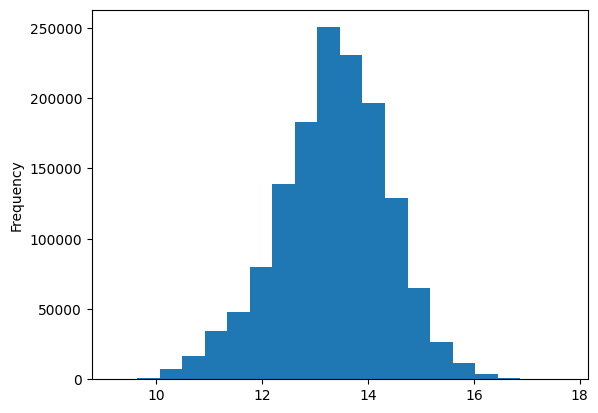

In [ ]:
data['log_price'].plot.hist(bins=20)

In [ ]:
double_regr.predict(data[data.actual_price.notna()]).to_csv('log_price_regr.csv', index=False)

<Axes: ylabel='Frequency'>

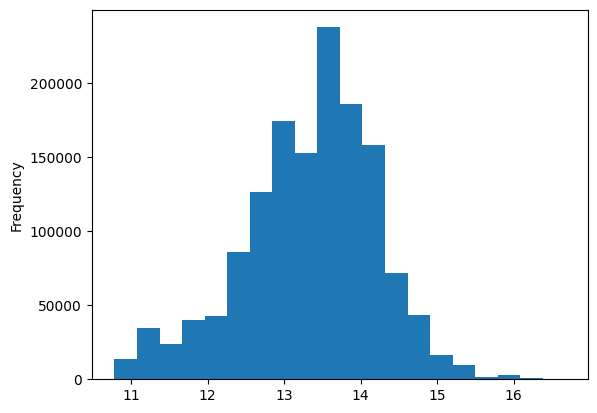

In [ ]:
double_regr.predict(data).plot.hist(bins=20)

In [ ]:
data_dealer = data[data['actual_price'].notna()].drop(labels=['start_date', 'close_date'], axis=1)
data_advert = data[data['actual_price'].isna()].drop(labels=['sale_end_date', 'actual_price', 'crashes', 'is_taxi', 'is_carsharing'], axis=1)

data_dealer['sale_end_date'] = pd.to_datetime(data_dealer['sale_end_date'])
data_advert['start_date'] = pd.to_datetime(data_advert['start_date'])
data_advert['close_date'] = pd.to_datetime(data_advert['close_date'])
data_advert['selling_time'] = (data_advert['close_date'] - data_advert['start_date']).dt.days

data_dealer.shape, data_advert.shape

((81426, 72), (1343058, 70))

In [ ]:
data.groupby(['brand']).model.count().le(13).sum()

1

In [ ]:
def get_metric(y_true, y_pred):
    bias = pd.Series((y_true - y_pred) / y_true * 100, name='bias')
    stats = pd.concat([
        bias.describe(),
        bias.abs().describe(),
    ], axis=1)
    stats.columns = ['bias', 'MAPE']

    return stats

def style_median_ape(df):
    color = 'background-color: lightgreen'
    df_style = pd.DataFrame('', index=df.index, columns=df.columns)
    df_style.loc['50%', 'MAPE'] = color
    return df_style

def show_top_errors(df, y_pred, top_k=10):
    x = df.copy()
    x['base_price'] = y_pred
    x['bias'] = (x['actual_price'] - y_pred) / x['actual_price'] * 100
    x['ape'] = np.abs(x['bias'])
    idx = np.argpartition(x['ape'].values, len(x['ape'].values) - top_k)[-top_k:]
    x = x[['bias', 'base_price', 'actual_price', 'price', 'sale_end_date', 'brand', 'model', 'generation', 'modification', 'year']]
    return x.iloc[idx]

In [ ]:
# data_dealer.to_csv('data_dealer.csv', index=False)
# data_advert.to_csv('data_advert.csv', index=False)

In [ ]:
data_advert['selling_time'] = data_advert['selling_time'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
selling_time_counts = data_advert['selling_time'].value_counts().sort_index()
selling_time_counts[(selling_time_counts.index > 7) & (selling_time_counts.index < 90)].sum()

744465

In [ ]:
data_advert.brand.unique()
(~data_advert.brand.isin(data_dealer.brand.unique())).sum()

1203

In [ ]:
# pd.Series(boxcox(data_advert.selling_time)[0]).plot.hist(bins=20)

<Axes: ylabel='Frequency'>

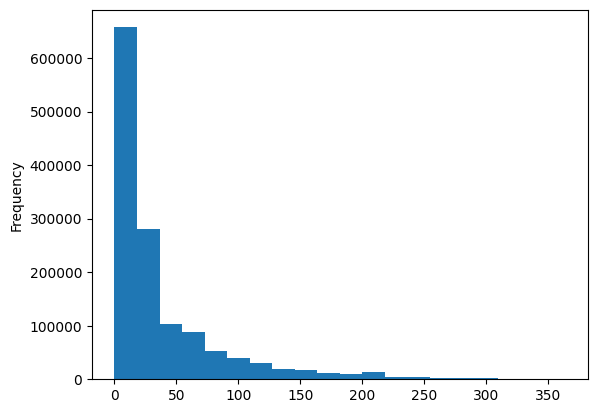

In [ ]:
data_advert.selling_time.plot.hist(bins=20)

<Axes: ylabel='Frequency'>

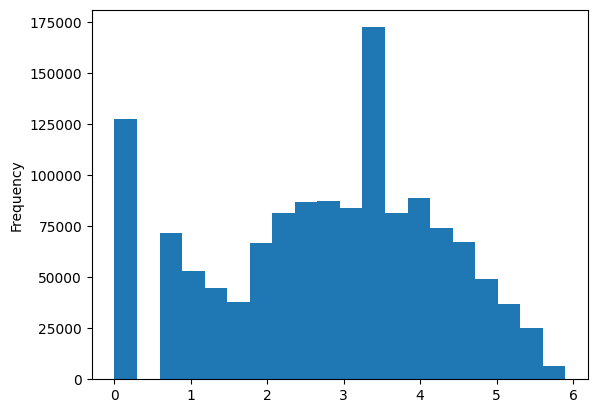

In [ ]:
data_advert.selling_time.apply(np.log1p).plot.hist(bins=20)

In [ ]:
data_advert.selling_time.apply(np.log1p).describe()

count    1.343058e+06
mean     2.775878e+00
std      1.491634e+00
min      0.000000e+00
25%      1.791759e+00
50%      2.995732e+00
75%      3.891820e+00
max      5.899897e+00
Name: selling_time, dtype: float64

In [ ]:
data_advert = data_advert[(data_advert.selling_time > 7) & (data_advert.selling_time < 90)]

(data_advert.selling_time == 30) & (data_advert.selling_time == 60)

In [ ]:
last_n_days = 30
last_date = data_advert['close_date'].max()
train_adv = data_advert[data_advert['close_date'] <= last_date - 2 * timedelta(last_n_days)]
val_adv = data_advert[(data_advert['close_date'] > last_date - 2 * timedelta(last_n_days)) & (data_advert['close_date'] <= last_date - timedelta(last_n_days))]
delayed_test_adv = data_advert[(data_advert['close_date'] > last_date - timedelta(last_n_days))]

print(f'Train rows: {train_adv.shape[0]}')
print(f'Min train date: {train_adv.close_date.min()}')
print(f'Max train date: {train_adv.close_date.max()}')
print(f'Val rows: {val_adv.shape[0]}')
print(f'Min val date: {val_adv.close_date.min()}')
print(f'Max val date: {val_adv.close_date.max()}')

Train rows: 615045
Min train date: 2022-03-08 14:05:39.764228
Max train date: 2022-12-30 00:40:57.749462
Val rows: 59606
Min val date: 2022-12-30 00:43:50.045770
Max val date: 2023-01-29 00:41:11.945669


In [ ]:
last_n_days = 30
last_date = data_dealer['sale_end_date'].max()
train = data_dealer[data_dealer['sale_end_date'] <= last_date - 2 * timedelta(last_n_days)]
val = data_dealer[(data_dealer['sale_end_date'] > last_date - 2 * timedelta(last_n_days)) & (data_dealer['sale_end_date'] <= last_date - timedelta(last_n_days))]
delayed_test = data_dealer[data_dealer['sale_end_date'] > last_date - timedelta(last_n_days)]

print(f'Train rows: {train.shape[0]}')
print(f'Min train date: {train.sale_end_date.min()}')
print(f'Max train date: {train.sale_end_date.max()}')
print(f'Val rows: {val.shape[0]}')
print(f'Min val date: {val.sale_end_date.min()}')
print(f'Max val date: {val.sale_end_date.max()}')

Train rows: 58301
Min train date: 2022-06-11 00:00:00
Max train date: 2022-12-07 00:00:00
Val rows: 11508
Min val date: 2022-12-08 00:00:00
Max val date: 2023-01-06 00:00:00


In [ ]:
grouper = BasePrice(['brand', 'model', 'year']) # avg price per week/month, использовать цены за последние 3 месяца
grouper.fit(data)
y_pred = grouper.predict(val)
get_metric(val['actual_price'].values, y_pred).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-4.748077,12.847611
std,27.252378,24.498221
min,-2211.265556,0.000000
25%,-12.969104,4.174493
50%,-2.065572,9.419479
75%,6.639017,17.098519
max,46.547573,2211.265556


In [ ]:
train.groupby(['brand', 'model'])['actual_price'].count().index.values.shape

(557,)

In [ ]:
data.groupby(['brand', 'model']).count().min().values

array([ 0, 11, 10, 10,  0, 11, 11,  4, 11, 11, 11, 11, 11, 11,  3, 11, 11,
       11, 11, 11, 11,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
       11, 11, 11, 11])

In [ ]:
show_top_errors(val, y_pred, top_k=100)

,bias,base_price,actual_price,price,sale_end_date,brand,model,generation,modification,year
726266,-62.272727,5.355000e+05,330000.0,330000.0,2022-12-24,Volvo,XC70,I рестайлинг (2004—2007),2.5 4WD AT (210 л.с.),2005
94887,-62.649006,1.951788e+06,1200000.0,1400000.0,2022-12-13,Skoda,Octavia,III рестайлинг (2017—2020),1.4 TSI DSG (150 л.с.),2020
500514,-62.651224,5.188574e+05,319000.0,510000.0,2022-12-19,Skoda,Fabia,II рестайлинг (2010—2014),1.4 MT (86 л.с.),2011
516497,-62.651224,5.188574e+05,319000.0,329000.0,2022-12-19,Skoda,Fabia,II рестайлинг (2010—2014),1.4 MT (86 л.с.),2011
1159780,-63.183894,1.378904e+06,845000.0,795000.0,2022-12-25,Audi,A3,8V (2012—2016),1.4 TFSI S tronic (125 л.с.),2016
...,...,...,...,...,...,...,...,...,...,...
1121895,-76.366867,4.409172e+05,250000.0,259000.0,2022-12-19,Hyundai,Elantra,III рестайлинг (2003—2010),1.6 MT (105 л.с.) ТагАЗ,2008
1255772,-125.025485,4.252982e+05,189000.0,249000.0,2022-12-23,Volkswagen,Touran,I рестайлинг (2006—2010),1.4 TSI MT (140 л.с.),2007
349488,-93.622803,6.234654e+05,322000.0,387000.0,2022-12-14,Kia,Picanto,II (2011—2015),1.0 MT (69 л.с.),2012
582927,-66.937623,5.091598e+05,305000.0,542000.0,2022-12-31,Nissan,Note,E11 рестайлинг (2008—2013),1.4 MT (88 л.с.),2010


In [ ]:
cat_features = [
    'brand',
    'model',
    'generation',
    'modification',
    'color',
    'body_type',
    'equipment',
    'owners_count',
]

num_features = [
    'year',
    'mileage',
    'latitude',
    'longitude',
]

train_adv[cat_features] = train_adv[cat_features].fillna('')
val[cat_features] = val[cat_features].fillna('')

features = cat_features + num_features

X_train = train_adv[features].reset_index(drop=True)
X_val = val[features].reset_index(drop=True)

y_train, y_val = train_adv['price'], val['actual_price']

In [ ]:
f = lambda x: x
inv_f = lambda x: x

transformation = "CoxBox"

if transformation == "Log":
    fy_train = np.log(y_train)
    fy_val = np.log(y_val)
    f = np.log
    inv_f = np.exp
elif transformation == "CoxBox":
    fy_train, fitted_lambda = boxcox(y_train, lmbda=None)
    fy_val = boxcox(y_val, lmbda=fitted_lambda)
    f = lambda x: boxcox(x, lmbda=fitted_lambda)
    inv_f = lambda x: inv_boxcox(x, fitted_lambda)

In [ ]:
fy_train.min(), fy_train.max()

(13.392913107902775, 37.62353333329347)

In [ ]:
fy_val.min(), fy_val.max()

(14.727516438241235, 34.50834456593219)

In [ ]:
np.random.seed(10)

params = dict(
    learning_rate=0.025,
    iterations=2000,
    # reg_lambda=0.0005,
    colsample_bylevel=1.,
    max_bin=80,
    # bagging_temperature=2,
    loss_function='RMSE', # 'MAE'
    use_best_model=True,
    verbose=False,
    # grow_policy='Depthwise',
    # random_seed=42,
    # od_pval=1.0
    used_ram_limit="8gb",
    eval_metric=MedianAPE(f, inv_f), # "MAPE"
)
model_adv = cb.CatBoostRegressor(
    **params,
)

eval_set = cb.Pool(data=X_val, label=fy_val, cat_features=cat_features)
model_adv.fit(X_train, fy_train, cat_features=cat_features, eval_set=eval_set, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
importances = list(zip(model_adv.feature_importances_, model_adv.feature_names_))
importances.sort(reverse=True)
importances

[(35.71194629195893, 'year'),
 (24.780998512490978, 'brand'),
 (11.359464135912457, 'body_type'),
 (10.271399866437157, 'generation'),
 (6.10109124059487, 'model'),
 (5.054378239848246, 'modification'),
 (3.4091763806918682, 'mileage'),
 (1.3810129911709184, 'equipment'),
 (0.6958672324733643, 'latitude'),
 (0.5806743012372259, 'owners_count'),
 (0.4909444798136776, 'longitude'),
 (0.16304632737025354, 'color')]

In [ ]:
last_n_days = 30
last_date = data_dealer['sale_end_date'].max()
train = data_dealer[data_dealer['sale_end_date'] <= last_date - 2 * timedelta(last_n_days)]
val = data_dealer[(data_dealer['sale_end_date'] > last_date - 2 * timedelta(last_n_days)) & (data_dealer['sale_end_date'] <= last_date - timedelta(last_n_days))]
delayed_test = data_dealer[data_dealer['sale_end_date'] > last_date - timedelta(last_n_days)]

print(f'Train rows: {train.shape[0]}')
print(f'Min train date: {train.sale_end_date.min()}')
print(f'Max train date: {train.sale_end_date.max()}')
print(f'Val rows: {val.shape[0]}')
print(f'Min val date: {val.sale_end_date.min()}')
print(f'Max val date: {val.sale_end_date.max()}')

Train rows: 58301
Min train date: 2022-06-11 00:00:00
Max train date: 2022-12-07 00:00:00
Val rows: 11508
Min val date: 2022-12-08 00:00:00
Max val date: 2023-01-06 00:00:00


Определим категориальные и численные признаки, которые будем использовать в обучении. Заполним пропущенные значения в категориальных признаках пустой строкой.

In [ ]:
cat_features = [
    'brand',
    'model',
    'generation',
    'modification',
    'color',
    'body_type',
    'equipment',
    'owners_count',
]

num_features = [
    'year',
    'mileage',
    'latitude',
    'longitude',
    'crashes',
    'is_taxi',
    'is_carsharing'
]

train[cat_features] = train[cat_features].fillna('')
val[cat_features] = val[cat_features].fillna('')

features = cat_features + num_features

X_train = train[features].reset_index(drop=True)
X_val = val[features].reset_index(drop=True)

y_train, y_val = train['actual_price'], val['actual_price']

Обучим CatBoostRegressor.

In [ ]:
np.random.seed(10)

params = dict(
    iterations=3800,
    colsample_bylevel=0.6621004943397027,
    depth=10,
    # max_bin=80,
    boosting_type='Plain',
    bootstrap_type='MVS',
    l2_leaf_reg=1.3946357860687908e-08,
    loss_function='MAE', # 'MAE'
    use_best_model=True,
    verbose=False,
    eval_metric=MedianAPE(f, inv_f),
    random_seed=42,
    # od_pval=1.0
)
model = cb.CatBoostRegressor(
    **params,
)

eval_set = cb.Pool(data=X_val, label=f(y_val), cat_features=cat_features)
model.fit(X_train, f(y_train), cat_features=cat_features, eval_set=eval_set, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model.tree_count_

3763

Посмотрим на метрики качества обученной модели. Видим, что medianAPE = 0.077510, а медиана сдвига (bias) = -0.022562.

Trial 28 finished with value: 6.992675313018867 and parameters: {'objective': 'RMSE', 'colsample_bylevel': 0.6621004943397027, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1.3946357860687908e-08, 'scaler': 0.9731799882485812}. Best is trial 28 with value: 6.992675313018867.

Best trial:
  Value: 7.21762707424735
  Params: 
    transformation: CoxBox
    objective: RMSE
    colsample_bylevel: 0.8818314784765143
    boosting_type: Plain
    depth: 10
    bootstrap_type: MVS
    l2_leaf_reg: 0.000301993341816763
    random_strength: 1.9105407452994366e-05

Best trial:
  Value: 7.221685017975302
  Params:
    boosting_type: Plain
    depth: 11
    bootstrap_type: MVS
    l2_leaf_reg: 0.6000809754492009
    random_strength: 7.901784842108324e-06

In [ ]:
model.get_all_params()['learning_rate']

0.029999999329447743

In [ ]:
model.best_iteration_

3762

In [ ]:
val['prediction'] = inv_f(model.predict(X_val))
val['bias'] = (val['actual_price'] - val['prediction']*1.0166) / val['actual_price'] * 100

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']

stats.style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-5.405888,11.371175
std,27.174322,25.265690
min,-2098.548488,0.000864
25%,-11.386729,3.419171
50%,-3.081398,7.510471
75%,3.778908,14.304002
max,87.425029,2098.548488


In [ ]:
best = float('inf')
best_ratio = 0
best_bias = 0
biases = [0, 1000, -1000, 5000, -5000, 20000, -20000]
for ratio in np.linspace(0.7, 1.3, num=1000):
    for bias in biases:
        temp = np.median((val['actual_price'] - (val['prediction']*ratio + bias)).abs() / val['actual_price'])
        if temp < best:
            best = temp
            best_ratio = ratio
            best_bias = bias
print(best * 100, best_ratio, best_bias)

7.194749198632302 0.9786786786786787 20000


In [ ]:
val['prediction'] = inv_f(model.predict(X_val))
val['bias'] = (val['actual_price'] - val['prediction']*best_ratio - best_bias) / val['actual_price'] * 100

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']

stats.style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-3.497699,10.970484
std,27.562800,25.526083
min,-2052.901634,0.000100
25%,-9.038093,3.315888
50%,-0.896964,7.194749
75%,5.747663,13.335375
max,87.238364,2052.901634


In [ ]:
y_new_train = y_train / inv_f(model.predict(X_train))

np.random.seed(10)

params = dict(
    iterations=3800,
    colsample_bylevel=0.6621004943397027,
    depth=10,
    # max_bin=80,
    boosting_type='Plain',
    bootstrap_type='MVS',
    l2_leaf_reg=1.3946357860687908e-08,
    loss_function='RMSE', # 'MAE'
    verbose=False,
    random_seed=42,
    # od_pval=1.0
)
model_scale = cb.CatBoostRegressor(
    **params,
)

model_scale.fit(X_train, y_new_train, cat_features=cat_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим на важность признаков для модели.

In [ ]:
importances = list(zip(model_scale.feature_importances_, model_scale.feature_names_))
importances.sort(reverse=True)
importances

[(12.50457013051076, 'modification'),
 (12.05499802139973, 'generation'),
 (10.45715912871993, 'brand'),
 (10.06966905971236, 'model'),
 (8.329566342686961, 'year'),
 (7.619579982719905, 'equipment'),
 (7.186823903969662, 'color'),
 (7.012826659954024, 'mileage'),
 (6.795042890614982, 'body_type'),
 (6.329134428123795, 'owners_count'),
 (4.839849525426891, 'longitude'),
 (4.693841934298048, 'latitude'),
 (1.850727186664895, 'crashes'),
 (0.2004116115488379, 'is_taxi'),
 (0.05579919364925795, 'is_carsharing')]

Сделаем предсказание на test и сохраним solution.csv.

In [ ]:
val['prediction_advert'] = inv_f(model_adv.predict(val[model_adv.feature_names_])) * model_scale.predict(val[model_scale.feature_names_])
val['prediction_dealer'] = inv_f(model.predict(val[model.feature_names_]))

In [ ]:
best = float('inf')
best_ratio = 0
for ratio_advert in tqdm(np.linspace(0.1, 1.0, num=250)):
    for ratio_dealer in np.linspace(0.1, 1.0, num=250):
        temp = np.median((val['actual_price'] - val['prediction_advert']*ratio_advert - val['prediction_dealer']*ratio_dealer).abs() / val['actual_price'])
        if temp < best:
            best = temp
            best_ratio = (ratio_advert, ratio_dealer)

100%|██████████| 250/250 [00:35<00:00,  7.00it/s]


In [ ]:
print(best, best_ratio)

0.07192447343957842 (0.12530120481927712, 0.8481927710843373)


In [ ]:
val['bias'] = (val['actual_price'] - val['prediction_advert']*best_ratio[0] - val['prediction_dealer']*best_ratio[1]) / val['actual_price']

stats = pd.concat([
    val.bias.describe(),
    val.bias.abs().describe(),
], axis=1)
stats.columns = ['bias', 'MAPE']

stats.style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11508.000000,11508.000000
mean,-0.017528,0.104103
std,0.256860,0.235470
min,-20.251392,0.000004
25%,-0.074041,0.033368
50%,0.004990,0.071924
75%,0.070463,0.129261
max,0.823187,20.251392


In [ ]:
delayed_test[cat_features] = delayed_test[cat_features].fillna('')
preds = inv_f(model_adv.predict(delayed_test[(model_adv.feature_names_)])) * model_scale.predict(delayed_test[(model_scale.feature_names_)])*best_ratio[0] + inv_f(model.predict(delayed_test[(model.feature_names_)]))*best_ratio[1]
get_metric(delayed_test['actual_price'].values, preds).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11617.000000,11617.000000
mean,0.606505,9.802895
std,16.795893,13.651552
min,-706.324733,0.000456
25%,-5.184569,3.465824
50%,2.261098,7.309445
75%,8.688294,12.634797
max,67.606473,706.324733


In [ ]:
preds = inv_f(model.predict(delayed_test[(model.feature_names_)]))
get_metric(delayed_test['actual_price'].values, preds).style.apply(style_median_ape, axis=None)

,bias,MAPE
count,11617.000000,11617.000000
mean,-1.230734,10.039748
std,18.011861,15.004558
min,-765.487087,0.000103
25%,-7.213124,3.330390
50%,0.440990,7.114135
75%,7.041514,12.775362
max,67.918315,765.487087


+0.12%

In [ ]:
preds = inv_f(model_adv.predict(test[(model_adv.feature_names_)])) * model_scale.predict(test[(model_scale.feature_names_)])*0.544 + inv_f(model.predict(test[(model.feature_names_)]))*0.4756

In [ ]:
pd.Series(preds).to_csv('solution_4.csv', header=False, index=False)